In [1]:
!pip install XGBoost
!pip install catboost
!pip install optuna

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

Оптимизация гиперпараметров XGBoost и CatBoost с использованием Optuna


Загрузка датасетов:


In [2]:
from sklearn.model_selection import train_test_split
df_m_train = pd.read_csv("train_Mortgage.csv")
df_p_train = pd.read_csv("train_Pension.csv")
df_s_train = pd.read_csv("train_Savings.csv")
target_name_1 = "Mortgage"
target_name_2 = "Pension"
target_name_3 = "Savings"
y_train_m = df_m_train[target_name_1]
y_train_p = df_p_train[target_name_2]
y_train_s = df_s_train[target_name_3]
X_train_m = df_m_train.drop(columns=[target_name_1])
X_train_p = df_p_train.drop(columns=[target_name_2])
X_train_s = df_s_train.drop(columns=[target_name_3])

In [3]:
df_m_valid = pd.read_csv("val_Mortgage.csv")
df_p_valid = pd.read_csv("val_Pension.csv")
df_s_valid = pd.read_csv("val_Savings.csv")
y_test_m = df_m_valid[target_name_1]
y_test_p = df_p_valid[target_name_2]
y_test_s = df_s_valid[target_name_3]
X_test_m = df_m_valid.drop(columns=[target_name_1])
X_test_p = df_p_valid.drop(columns=[target_name_2])
X_test_s = df_s_valid.drop(columns=[target_name_3])

In [4]:
X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(X_train_m, y_train_m, test_size = 0.2, stratify=y_train_m)
X_train_p, X_valid_p, y_train_p, y_valid_p = train_test_split(X_train_p, y_train_p, test_size = 0.2, stratify=y_train_p)
X_train_s, X_valid_s, y_train_s, y_valid_s = train_test_split(X_train_s, y_train_s, test_size = 0.2, stratify=y_train_s)

In [5]:
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    roc_auc_score,
    precision_score,
    recall_score,
    roc_curve,
)
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, pos_label='yes'):
    """
    Вычисляет метрики и строит график AUC для модели CatBoostClassifier.

    Параметры:
        model: Обученная модель CatBoostClassifier.
        X_test: Тестовые данные (признаки).
        y_test: Истинные значения целевой переменной.

    Возвращает:
        Словарь с метриками: accuracy, f1_score, roc_auc, precision, recall.
    """
    # Предсказание вероятностей и классов
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Вероятности для положительного класса
    y_pred = model.predict(X_test)  # Предсказанные классы

    # Вычисление метрик
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, pos_label=pos_label)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, pos_label=pos_label)
    recall = recall_score(y_test, y_pred, pos_label=pos_label)
    # Возвращение метрик
    return {
        "accuracy": accuracy,
        "f1_score": f1,
        "roc_auc": roc_auc,
        "precision": precision,
        "recall": recall,
    }

Рассмотрим дефолтные модели.


In [7]:
print("Default catboost for mortgage ")
default_model_m = CatBoostClassifier(verbose=0)
default_model_m.fit(X_train_m,
          y_train_m,
          verbose=False)
evaluate_model(default_model_m,X_test_m, y_test_m, pos_label=1)

Default catboost for mortgage 


{'accuracy': 0.7702702702702703,
 'f1_score': 0.7233273056057866,
 'roc_auc': 0.9388262136009884,
 'precision': 0.9090909090909091,
 'recall': 0.6006006006006006}

In [8]:
print("Default catboost for pension ")
default_model_p = CatBoostClassifier(verbose=0)
default_model_p.fit(X_train_p,
          y_train_p,
          verbose=False)
evaluate_model(default_model_p,X_test_p, y_test_p, pos_label=1)

Default catboost for pension 


{'accuracy': 0.5560081466395111,
 'f1_score': 0.2534246575342466,
 'roc_auc': 0.7570360169403645,
 'precision': 0.7956989247311828,
 'recall': 0.15071283095723015}

In [9]:
print("Default catboost for savings")
default_model_s = CatBoostClassifier(verbose=0)
default_model_s.fit(X_train_s,
          y_train_s,
          verbose=False)
evaluate_model(default_model_s,X_test_s, y_test_s, pos_label=1)

Default catboost for savings


{'accuracy': 0.5775147928994083,
 'f1_score': 0.45161290322580644,
 'roc_auc': 0.6692993942789118,
 'precision': 0.6433260393873085,
 'recall': 0.3479289940828402}

In [14]:
print("Default XGBoost for mortgage ")
default_model_m = XGBClassifier()
default_model_m.fit(X_train_m,
          y_train_m,)
evaluate_model(default_model_m,X_test_m, y_test_m, pos_label=1)

Default XGBoost for mortgage 


{'accuracy': 0.7597597597597597,
 'f1_score': 0.706959706959707,
 'roc_auc': 0.9364544724905085,
 'precision': 0.9061032863849765,
 'recall': 0.5795795795795796}

Дефолтный XGBoost чуть хуже дефолтного Castboost

In [15]:
print("Default XGBoost for pension ")
default_model_p = XGBClassifier()
default_model_p.fit(X_train_p,
          y_train_p,)
evaluate_model(default_model_p,X_test_p, y_test_p, pos_label=1)

Default XGBoost for pension 


{'accuracy': 0.5621181262729125,
 'f1_score': 0.33229813664596275,
 'roc_auc': 0.7300907163982229,
 'precision': 0.6993464052287581,
 'recall': 0.21792260692464357}

In [16]:
print("Default XGBoost for savings")
default_model_s = XGBClassifier()
default_model_s.fit(X_train_s,
          y_train_s,)
evaluate_model(default_model_s,X_test_s, y_test_s, pos_label=1)

Default XGBoost for savings


{'accuracy': 0.5715976331360947,
 'f1_score': 0.4806312769010043,
 'roc_auc': 0.6473771926753266,
 'precision': 0.6102003642987249,
 'recall': 0.39644970414201186}

In [17]:
def optimizers(model_lib,X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 10),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 10),
        'tree_method': 'hist',
        'random_state': 42,
    }
    model = model_lib(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=n_trials)
  return study.best_params

In [18]:
best_m_XGBoost = optimizers(XGBClassifier, X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 350)

[I 2025-03-21 13:20:22,115] A new study created in memory with name: no-name-42a2354d-7804-4ad9-b918-44f2fb44c167
[I 2025-03-21 13:20:22,588] Trial 0 finished with value: 0.9489068130941505 and parameters: {'n_estimators': 892, 'max_depth': 11, 'learning_rate': 0.24409376725708817, 'subsample': 0.8438921776010675, 'colsample_bytree': 0.5011996621127357, 'min_child_weight': 7, 'gamma': 3.354328255323245, 'reg_alpha': 3.8643682422888026, 'reg_lambda': 2.839706360973002, 'scale_pos_weight': 6.802001999921291}. Best is trial 0 with value: 0.9489068130941505.
[I 2025-03-21 13:20:22,903] Trial 1 finished with value: 0.9540301856108898 and parameters: {'n_estimators': 636, 'max_depth': 3, 'learning_rate': 0.18020381374016498, 'subsample': 0.698416852815652, 'colsample_bytree': 0.7588886240276672, 'min_child_weight': 4, 'gamma': 4.242309217781074, 'reg_alpha': 4.256568662368398, 'reg_lambda': 8.652738354186747, 'scale_pos_weight': 1.700755787250778}. Best is trial 1 with value: 0.9540301856108

In [19]:
best_model_m_xg = XGBClassifier(**best_m_XGBoost)
best_model_m_xg.fit(X_train_m,y_train_m)
evaluate_model(best_model_m_xg, X_test_m, y_test_m, pos_label=1)

{'accuracy': 0.7927927927927928,
 'f1_score': 0.7570422535211268,
 'roc_auc': 0.9411077744411078,
 'precision': 0.9148936170212766,
 'recall': 0.6456456456456456}

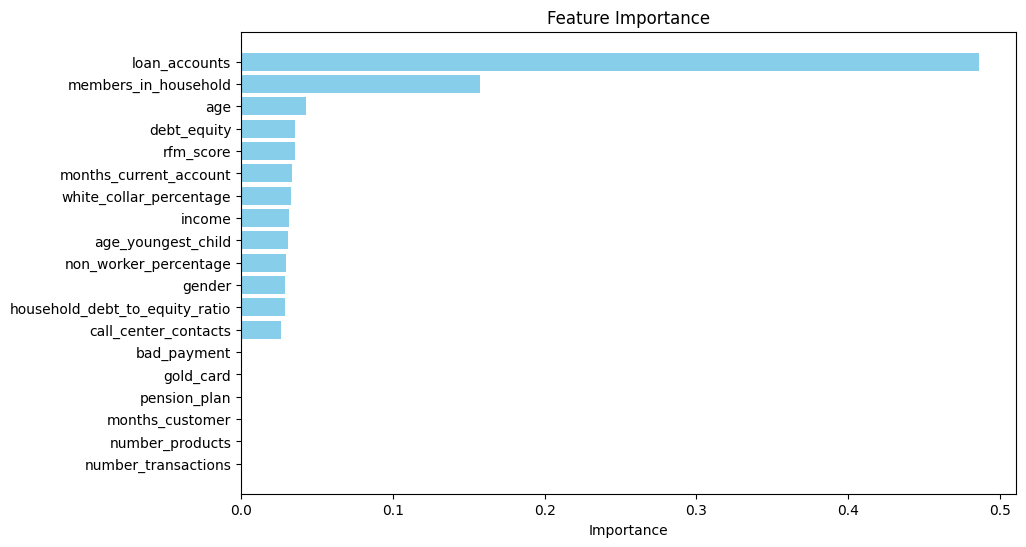

In [24]:
importances = best_model_m_xg.feature_importances_
fi_df = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

In [20]:
best_p_XGBoost = optimizers(XGBClassifier, X_train_p, y_train_p, X_test_p, y_test_p, n_trials = 350)

[I 2025-03-21 13:27:55,389] A new study created in memory with name: no-name-fbfbcbc3-9fde-42de-9373-2ced0ffcf3cb
[I 2025-03-21 13:27:55,995] Trial 0 finished with value: 0.7687167383576474 and parameters: {'n_estimators': 1304, 'max_depth': 11, 'learning_rate': 0.2839418746988014, 'subsample': 0.5834964603695607, 'colsample_bytree': 0.5418970042733475, 'min_child_weight': 3, 'gamma': 2.6463835698455727, 'reg_alpha': 7.966685497105569, 'reg_lambda': 5.8362510266645495, 'scale_pos_weight': 1.0226045282492269}. Best is trial 0 with value: 0.7687167383576474.
[I 2025-03-21 13:27:56,619] Trial 1 finished with value: 0.7478233456804975 and parameters: {'n_estimators': 1041, 'max_depth': 4, 'learning_rate': 0.17872716277323594, 'subsample': 0.8019193768612228, 'colsample_bytree': 0.7106568834919258, 'min_child_weight': 9, 'gamma': 2.8270518291449314, 'reg_alpha': 9.284069438503806, 'reg_lambda': 1.9909097815426702, 'scale_pos_weight': 6.921147572913592}. Best is trial 0 with value: 0.7687167

In [21]:
best_model_p_xg = XGBClassifier(**best_p_XGBoost)
best_model_p_xg.fit(X_train_p, y_train_p)
evaluate_model(best_model_p_xg, X_test_p, y_test_p, pos_label=1)

{'accuracy': 0.5437881873727087,
 'f1_score': 0.18248175182481752,
 'roc_auc': 0.7779895553776532,
 'precision': 0.8771929824561403,
 'recall': 0.10183299389002037}

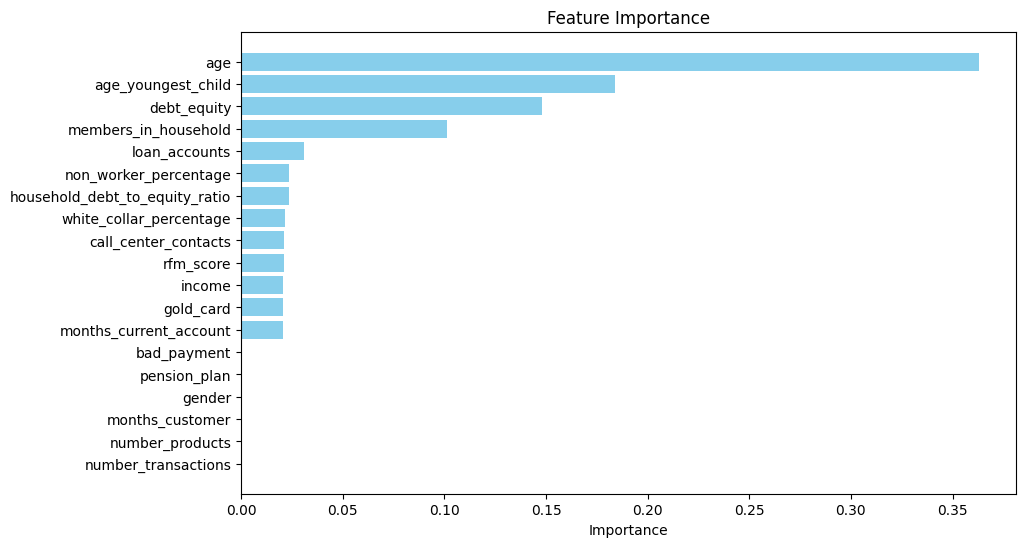

In [25]:
importances = best_model_p_xg.feature_importances_
fi_df = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

In [22]:
best_s_XGBoost = optimizers(XGBClassifier, X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 350)

[I 2025-03-21 13:30:31,618] A new study created in memory with name: no-name-efa2b76c-a9e0-4235-979b-6cd341c1075b
[I 2025-03-21 13:30:31,932] Trial 0 finished with value: 0.6619190251914376 and parameters: {'n_estimators': 545, 'max_depth': 14, 'learning_rate': 0.21414657896358347, 'subsample': 0.8626474296901252, 'colsample_bytree': 0.8231929746609521, 'min_child_weight': 1, 'gamma': 4.862814796635505, 'reg_alpha': 5.635639616203376, 'reg_lambda': 5.9112730389964065, 'scale_pos_weight': 4.567016607637433}. Best is trial 0 with value: 0.6619190251914376.
[I 2025-03-21 13:30:32,205] Trial 1 finished with value: 0.6658844195962409 and parameters: {'n_estimators': 401, 'max_depth': 15, 'learning_rate': 0.2899638348133637, 'subsample': 0.9966163237164263, 'colsample_bytree': 0.8629193385198455, 'min_child_weight': 6, 'gamma': 3.2585915528734253, 'reg_alpha': 5.150641475862827, 'reg_lambda': 3.934223566432907, 'scale_pos_weight': 8.974574607078466}. Best is trial 1 with value: 0.66588441959

In [23]:
best_model_s_xg = XGBClassifier(**best_s_XGBoost)
best_model_s_xg.fit(X_train_s,y_train_s)
evaluate_model(best_model_s_xg, X_test_s, y_test_s, pos_label=1)

{'accuracy': 0.5899408284023668,
 'f1_score': 0.6948480845442536,
 'roc_auc': 0.6912496061062287,
 'precision': 0.5532959326788219,
 'recall': 0.9337278106508876}

Это лучший скор, который получался для `Savings`


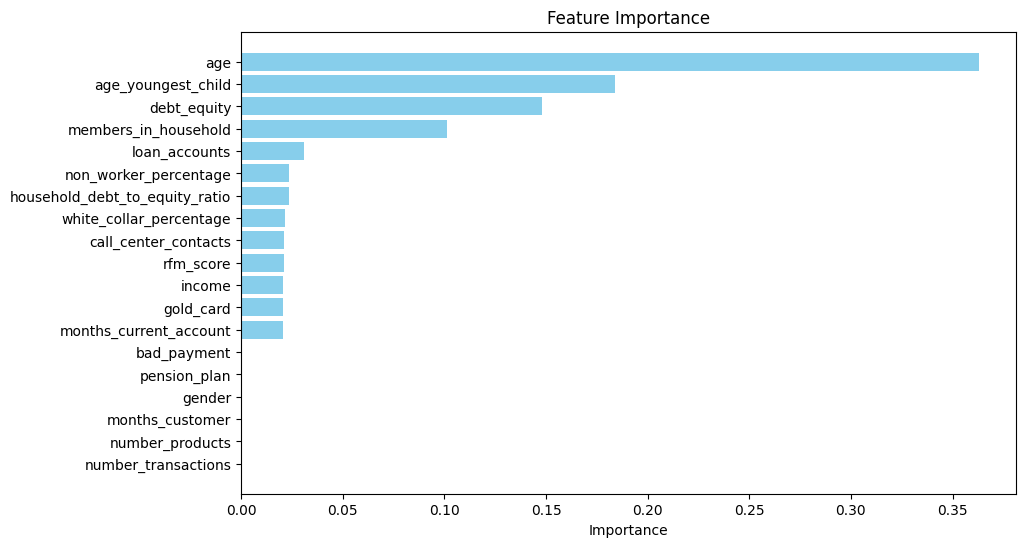

In [27]:
importances = best_model_p_xg.feature_importances_
fi_df = pd.DataFrame({"Feature": X_test_m.columns, "Importance": importances})
fi_df = fi_df.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10,6))
plt.barh(fi_df["Feature"], fi_df["Importance"], color="skyblue")
plt.gca().invert_yaxis()
plt.xlabel("Importance")
plt.title("Feature Importance")
plt.show()

Сравним с catboost


In [32]:
def optimizers_catboost(X_train, y_train, X_valid, y_valid, n_trials=10):
  def objective(trial):
    params = {
        'iterations': 1000,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10.0, log=True),
        'random_strength': trial.suggest_float('random_strength', 1e-3, 10.0, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.2,0.7),
        "max_depth": trial.suggest_int("depth", 1, 8),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        'verbose': False,
        'random_state': 42,
    }
    model = CatBoostClassifier(**params)
    model.fit(X_train, y_train)
    y_pred_proba = model.predict_proba(X_valid)[:, 1]
    y_pred = model.predict(X_valid)
    return roc_auc_score(y_valid, y_pred_proba)

  study = optuna.create_study(direction='maximize')
  study.optimize(objective, n_trials=n_trials)
  return study.best_params

In [33]:
best_m = optimizers_catboost(X_train_m, y_train_m, X_valid_m, y_valid_m, n_trials = 30)

[I 2025-03-21 13:42:52,135] A new study created in memory with name: no-name-a93c9ada-630a-456b-aecb-d1663e24a155
[I 2025-03-21 13:42:55,411] Trial 0 finished with value: 0.9347676601383299 and parameters: {'learning_rate': 0.05724853097972052, 'l2_leaf_reg': 0.010823752956630187, 'random_strength': 0.002183939063532861, 'bagging_temperature': 0.3421803574626031, 'border_count': 116, 'colsample_bylevel': 0.4706229910434872, 'depth': 7, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.9347676601383299.
[I 2025-03-21 13:43:05,048] Trial 1 finished with value: 0.9543765120411175 and parameters: {'learning_rate': 0.030839147330683714, 'l2_leaf_reg': 3.608521714744474, 'random_strength': 0.3461656430266281, 'bagging_temperature': 0.6551579610346093, 'border_count': 181, 'colsample_bylevel': 0.35488697199456953, 'depth': 1, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.9543765120411175.
[I 2025-03-21 13:43:16,345] Trial 2 finished with value: 0.9485379001576036 and param

In [34]:
best_model_m = CatBoostClassifier(**best_m, verbose=250)
best_model_m.fit(X_train_m,y_train_m)
evaluate_model(best_model_m, X_test_m, y_test_m, pos_label=1)

0:	learn: 0.6746466	total: 2.26ms	remaining: 2.26s
250:	learn: 0.2068326	total: 533ms	remaining: 1.59s
500:	learn: 0.1966608	total: 1.06s	remaining: 1.06s
750:	learn: 0.1916162	total: 1.59s	remaining: 528ms
999:	learn: 0.1877187	total: 2.13s	remaining: 0us


{'accuracy': 0.7867867867867868,
 'f1_score': 0.74822695035461,
 'roc_auc': 0.941549657765874,
 'precision': 0.9134199134199135,
 'recall': 0.6336336336336337}

In [37]:
best_p = optimizers_catboost(X_train_p, y_train_p, X_test_p, y_test_p, n_trials = 30)

[I 2025-03-21 13:49:20,828] A new study created in memory with name: no-name-0c49b446-71fc-4675-80e2-19158d69b0be
[I 2025-03-21 13:49:25,164] Trial 0 finished with value: 0.720902933039103 and parameters: {'learning_rate': 0.2122106017757631, 'l2_leaf_reg': 4.344339362686994, 'random_strength': 0.003035094023170461, 'bagging_temperature': 0.5941796687778922, 'border_count': 173, 'colsample_bylevel': 0.35952173243455077, 'depth': 7, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.720902933039103.
[I 2025-03-21 13:49:33,593] Trial 1 finished with value: 0.7730181972034296 and parameters: {'learning_rate': 0.035822052948167774, 'l2_leaf_reg': 5.0023240710189745, 'random_strength': 0.001083641629361849, 'bagging_temperature': 0.36003099338288225, 'border_count': 195, 'colsample_bylevel': 0.28893089303741, 'depth': 1, 'boosting_type': 'Ordered'}. Best is trial 1 with value: 0.7730181972034296.
[I 2025-03-21 13:49:45,407] Trial 2 finished with value: 0.7181486720230961 and parameter

In [38]:
best_model_p = CatBoostClassifier(**best_p, verbose=250)
best_model_p.fit(X_train_p, y_train_p)
evaluate_model(best_model_p, X_test_p, y_test_p, pos_label=1)

0:	learn: 0.6736209	total: 11.3ms	remaining: 11.2s
250:	learn: 0.4267778	total: 3.05s	remaining: 9.09s
500:	learn: 0.4223158	total: 5.59s	remaining: 5.57s
750:	learn: 0.4206379	total: 8.2s	remaining: 2.72s
999:	learn: 0.4195999	total: 10.8s	remaining: 0us


{'accuracy': 0.5305498981670062,
 'f1_score': 0.1383177570093458,
 'roc_auc': 0.7757620882607921,
 'precision': 0.8409090909090909,
 'recall': 0.07535641547861507}

In [39]:
best_s = optimizers_catboost(X_train_s, y_train_s, X_valid_s, y_valid_s, n_trials = 30)

[I 2025-03-21 13:54:01,746] A new study created in memory with name: no-name-8fc1599c-0438-4713-89c1-104873bae00a
[I 2025-03-21 13:54:12,000] Trial 0 finished with value: 0.6616661318743473 and parameters: {'learning_rate': 0.030882854528778498, 'l2_leaf_reg': 0.5023106412508483, 'random_strength': 0.007960669654061793, 'bagging_temperature': 0.6025133321864151, 'border_count': 231, 'colsample_bylevel': 0.4043339644438628, 'depth': 2, 'boosting_type': 'Ordered'}. Best is trial 0 with value: 0.6616661318743473.
[I 2025-03-21 13:54:15,106] Trial 1 finished with value: 0.6336031315262791 and parameters: {'learning_rate': 0.11193208888806422, 'l2_leaf_reg': 0.1768861863241994, 'random_strength': 0.0038815962620261752, 'bagging_temperature': 0.5238872919609084, 'border_count': 171, 'colsample_bylevel': 0.47560413822038106, 'depth': 6, 'boosting_type': 'Plain'}. Best is trial 0 with value: 0.6616661318743473.
[I 2025-03-21 13:54:25,888] Trial 2 finished with value: 0.6596089943003829 and par

In [40]:
best_model_s = CatBoostClassifier(**best_s, verbose=250)
best_model_s.fit(X_train_s,y_train_s)
evaluate_model(best_model_s, X_test_s, y_test_s, pos_label=1)

0:	learn: 0.6915658	total: 4.64ms	remaining: 4.64s
250:	learn: 0.6073989	total: 589ms	remaining: 1.76s
500:	learn: 0.5992738	total: 1.2s	remaining: 1.2s
750:	learn: 0.5938313	total: 1.79s	remaining: 595ms
999:	learn: 0.5876487	total: 2.41s	remaining: 0us


{'accuracy': 0.5840236686390533,
 'f1_score': 0.4398406374501992,
 'roc_auc': 0.6901249956234026,
 'precision': 0.6731707317073171,
 'recall': 0.32662721893491126}